In [1]:
from typing import List
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
COLS = [
    "PESEL",
    "wiek w chwili badania",
    "Czas trwania choroby",
    "Age w momencie diagnozy PZS",
    "Focus score",
    "SSA", #positive, negative
    "SSB", #positive, negative
    "RF", #positive, negative
    "C3wyjściowo", #low, normal, high
    "C4 wyjściowo", #low, normal, high
    "Lymphadenopathy",
    "Glandular",
    "Articular",
    "Cutaneous",
    "Pulmonary",
    "wyjściowy ESSDAI",
    "ESSDAI bad MRI",
    "ESSPRi suchośc 0-10",
    "ESSPRI fatigue 0-10",
    "ESSPRI pain 0-10",
    "Hb",
    "neutrofile",
    "limfocyty",
    "OB.",
    "CRP",
    "RF wartość",
    "nieprawidłowy RF",
    "IgG",
    "igG nieprawidłowe",
    "gammaglobuliny",
    "gammaglobuliny poza normą",
    "dodatnie krioglobulin",
    "Ro52",
    "plaquenil 200 mg",
    "witamina D3 1000 j.m.- ilość kaps",
    "prednizon mg",
    "NT",
    "niedoczynność tarczycy",
]

In [3]:
def ordinal_categorical_to_numerical(df: pd.DataFrame, column: str, order: List[int]):
    df[column] = df[column].astype('category')
    df[column].cat.categories = order
    df[column] = df[column].astype('int')

    return df

def load_data(db_path: str, tracto_dir: str):
    def load_tractography(tracto_dir: str):

        dfs = []
        patient_ids = os.listdir(tracto_dir)

        for patient_id in patient_ids:
            patient_path = os.path.join(tracto_dir, patient_id, "stats.csv")
            df = pd.read_csv(patient_path)
            
            df["patient_id"] = int(patient_id.split("-")[0])
            dfs.append(df)
        
        df = pd.concat(dfs).reset_index().drop(["Unnamed: 0", "index"], axis=1)

        # Fill missing MD values with the mean
        mean_value = df['mean MD'].mean()
        df['mean MD'].fillna(value=mean_value, inplace=True)

        return df
    
    db = pd.read_excel(db_path)
    db = db.fillna(0)
    tracto_db = load_tractography(tracto_dir)

    ids = set(db["PESEL"]) & set(tracto_db["patient_id"])
    db = db[db["PESEL"].isin(ids)]
    tracto_db = tracto_db[tracto_db["patient_id"].isin(ids)]

    return db, tracto_db

In [35]:
def plot_correlations(df: pd.DataFrame, tracto_df: pd.DataFrame, metric: str, top: int = 10):
    tracto_df = tracto_df[["patient_id", "bundle", metric]]
    full_df = pd.merge(df, tracto_df, left_on='PESEL', right_on='patient_id').drop(["patient_id"], axis=1)
    corrs = []

    bundles = pd.unique(full_df["bundle"])

    # Compute correlations
    for bundle in bundles:
        clinical_df = full_df[full_df["bundle"] == bundle]
        corr = clinical_df.corr()[metric].drop([metric, "PESEL"])
        corrs.append(corr)

    corrs_df = pd.concat(corrs, axis=1)
    corrs_df.columns = bundles

    corrs_df = corrs_df.loc[corrs_df.abs().max(axis=1).sort_values(ascending=False).index]

    fig, axes = plt.subplots(len(COLS) - 1, 1, figsize=(15, 25))
    axes[0].set_title(
        f"Correlations of '{metric}' in the bundles with the clinical features (top {top} correlating bundles)", 
    )
    
    # Plot correlations
    for ax, col in tqdm(zip(axes, corrs_df.index), total=len(COLS) - 1):
        corr = corrs_df.loc[col]
        idx = corr.abs().sort_values(ascending=False)[:top].index

        sns.heatmap(
            corr.loc[idx].to_numpy()[..., None].T, 
            annot=True, 
            linewidths=1, 
            linecolor='black', 
            clip_on=False, 
            xticklabels=idx,
            yticklabels=[col],
            vmin=-0.8, 
            vmax=0.8, 
            cbar=False,
            cmap="icefire",
            ax=ax
        )
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    fig.tight_layout()
    plt.savefig(f"correlations_{metric}.jpg", transparent=False)

In [5]:
df, tracto_df = load_data(
    "data/baza kliniczna.xlsx",
    "data/Sjogren_DICOM_grupa_badana",
)

df = ordinal_categorical_to_numerical(df, "SSA", [0, 1])
df = ordinal_categorical_to_numerical(df, "SSB", [0, 1])
df = ordinal_categorical_to_numerical(df, "RF", [0, 1])

df = ordinal_categorical_to_numerical(df, "C3wyjściowo", [0, 1])
df = ordinal_categorical_to_numerical(df, "C4 wyjściowo", [0, 1])

df = df[COLS]

  0%|          | 0/37 [00:00<?, ?it/s]

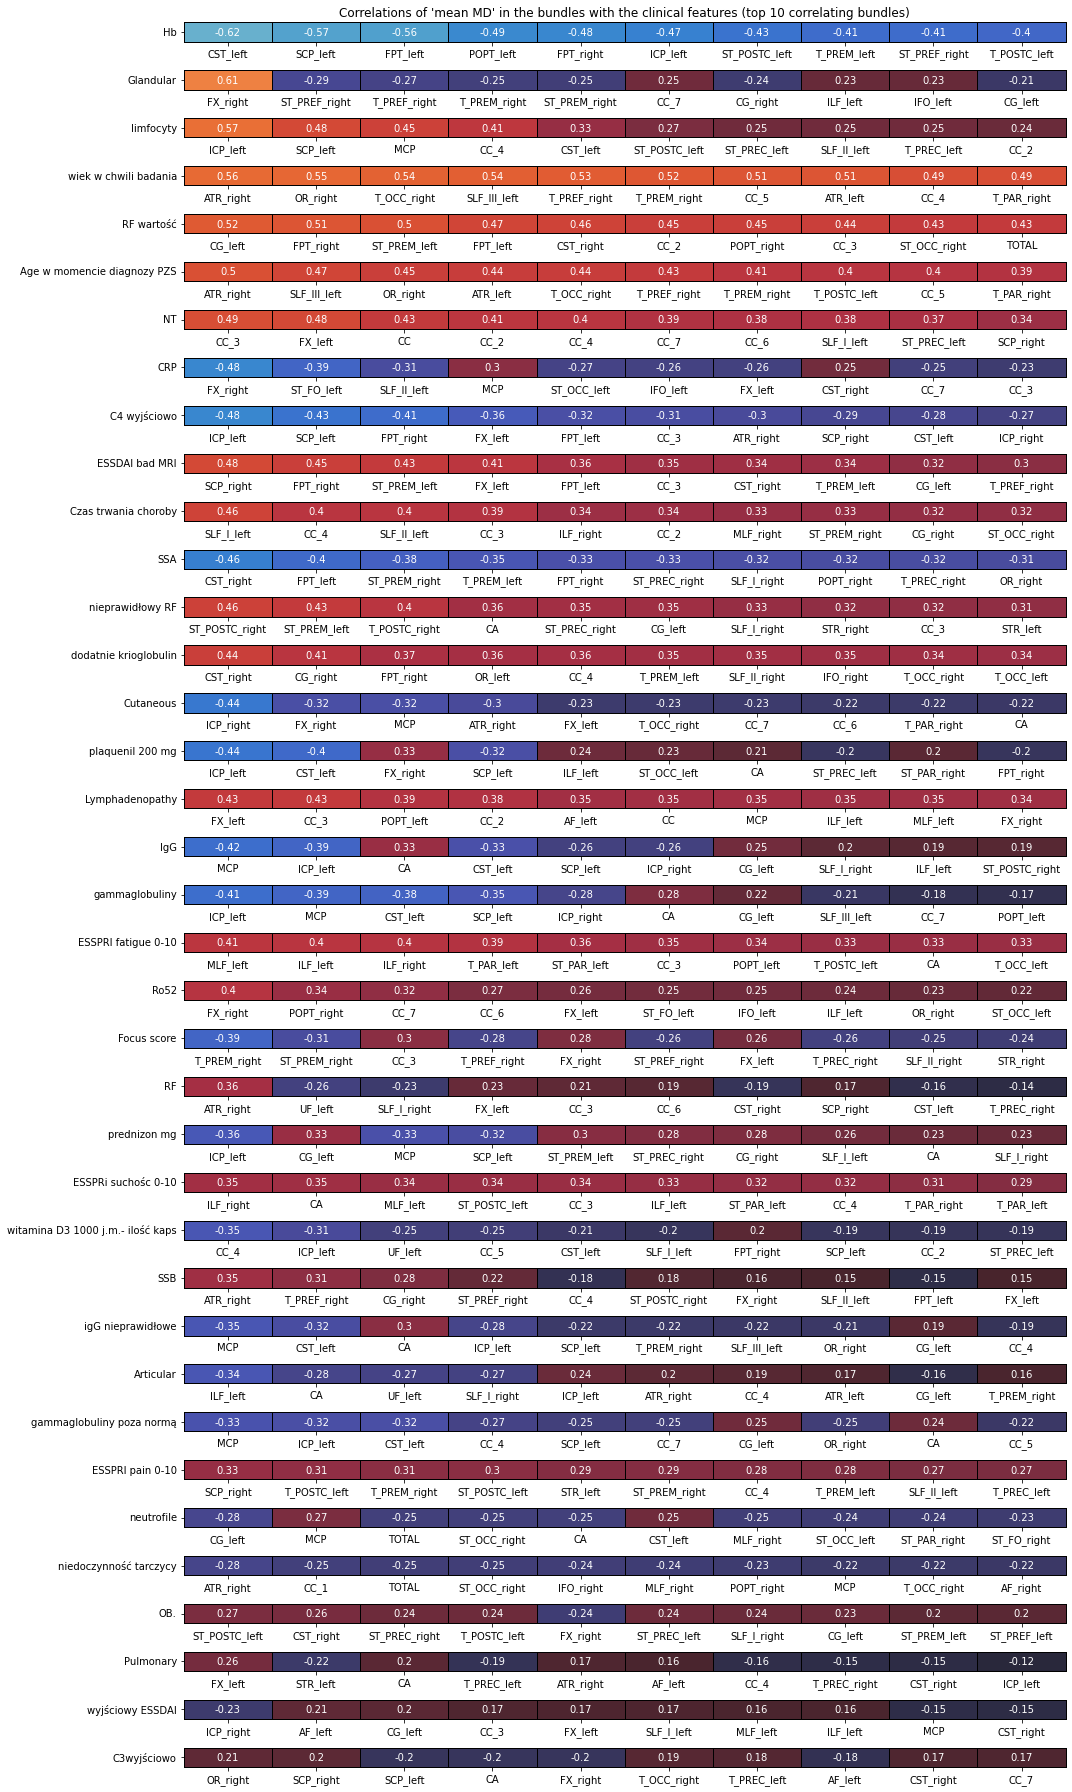

In [36]:
plot_correlations(df, tracto_df, "mean MD")

  0%|          | 0/37 [00:00<?, ?it/s]

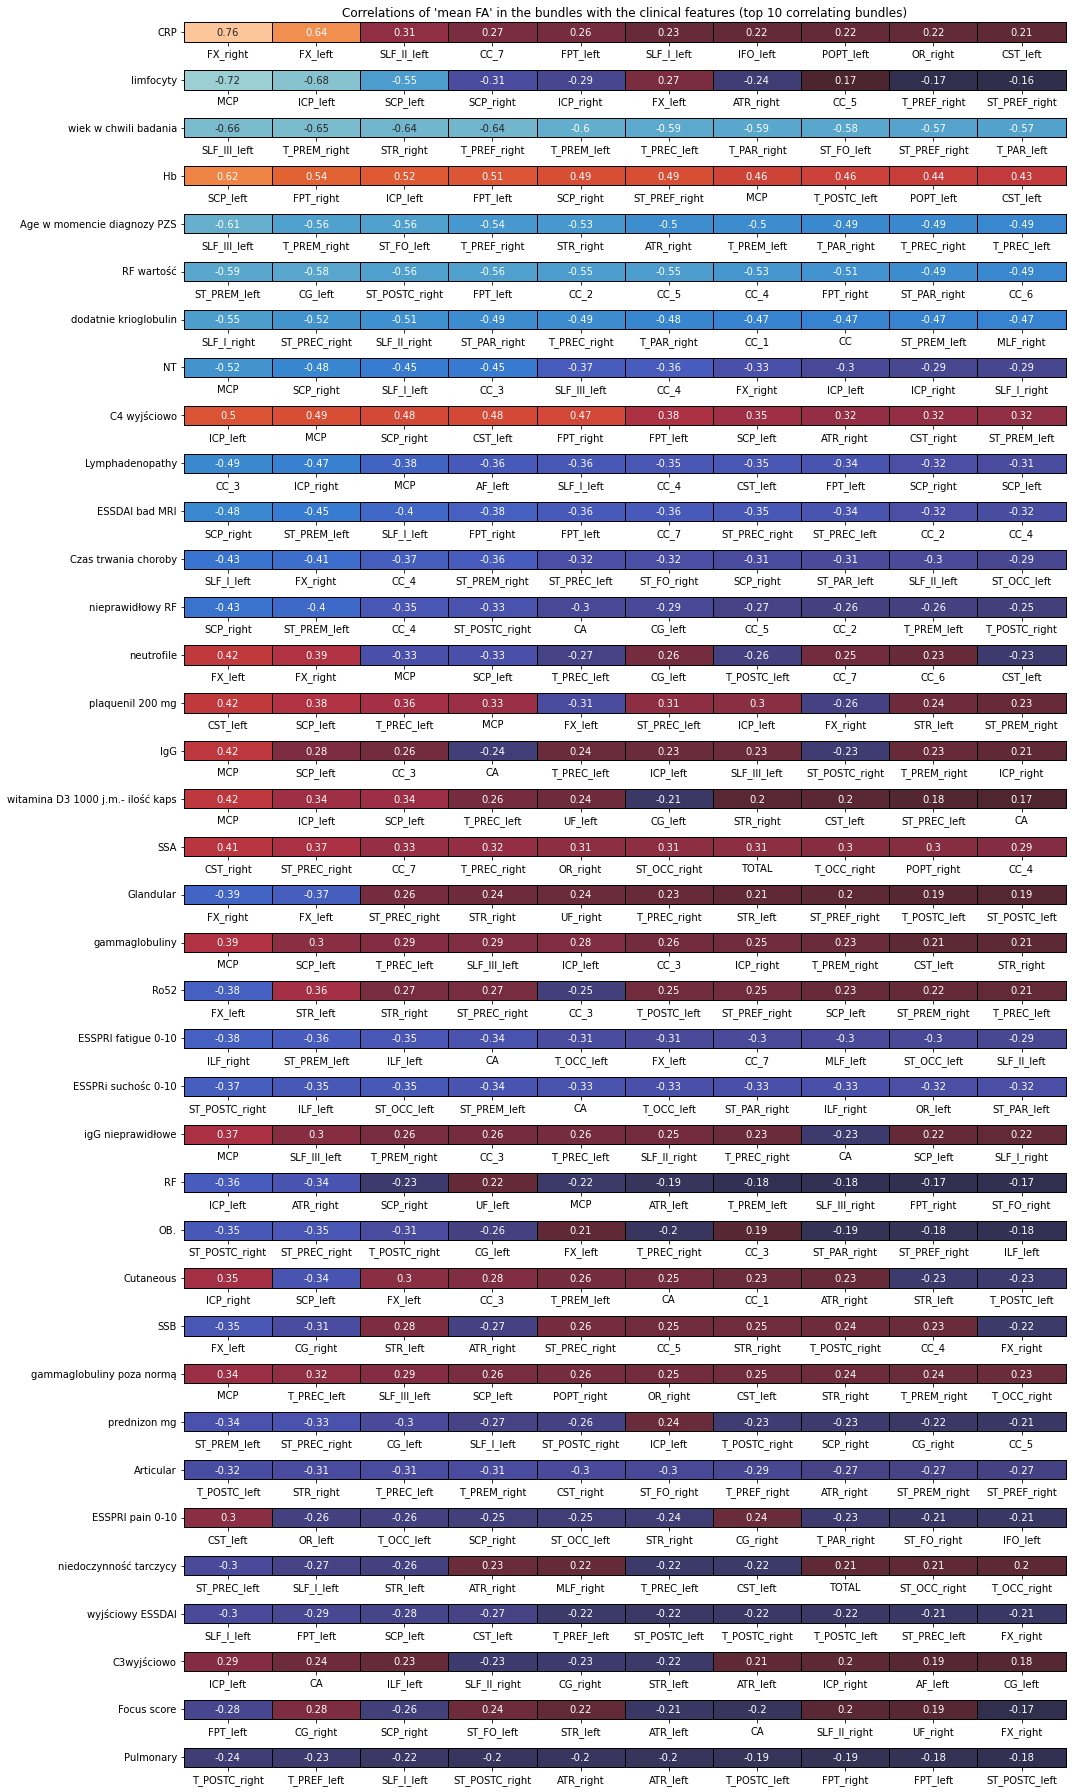

In [37]:
plot_correlations(df, tracto_df, "mean FA")